In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shutil
import os
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict

2025-08-14 09:45:08.106945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755164708.301545      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755164708.357694      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

data_path = "/kaggle/input/nlp-stock-data/indo_raw_with_emoji.csv"
label_encoder = LabelEncoder()

# Data Preparation

In [3]:
df = pd.read_csv(data_path)
df.dropna(subset=['Processed_Sentence', 'Sentiment'], inplace=True)

X = df['Processed_Sentence'].tolist()
y = label_encoder.fit_transform(df['Sentiment'])
NUM_LABELS = len(label_encoder.classes_)

print("Label mapping:", {i: label for i, label in enumerate(label_encoder.classes_)})

Label mapping: {0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Data split - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Data split - Train: 2301, Val: 493, Test: 494


# Tokenizer

In [5]:
def setup_bert_model_and_tokenizer(model_name, num_labels=3):
    print(f"\n--- Initializing model and tokenizer from '{model_name}' ---")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    
    return model, tokenizer

# Model

In [6]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    return {
        'accuracy': accuracy, 
        'f1_macro': f1_macro
    }

In [7]:
model, tokenizer = setup_bert_model_and_tokenizer(
    model_name='indolem/indobertweet-base-uncased',
    num_labels=len(np.unique(y_train))
)


--- Initializing model and tokenizer from 'indolem/indobertweet-base-uncased' ---


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def train_bert_model(model, tokenizer, X_train, y_train, X_val, y_val):
    output_dir = './indobert_custom_results'

    train_df = pd.DataFrame({'text': X_train, 'label': y_train})
    val_df = pd.DataFrame({'text': X_val, 'label': y_val})

    hf_datasets = DatasetDict({
        'train': Dataset.from_pandas(train_df),
        'validation': Dataset.from_pandas(val_df)
    })

    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

    tokenized_datasets = hf_datasets.map(tokenize_function, batched=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=5,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        seed=42,
        greater_is_better=True,
        report_to="none",
        logging_strategy="epoch",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )

    trainer.train()
    
    return trainer

In [11]:
trainer = train_bert_model(model, tokenizer, X_train, y_train, X_val, y_val)

Map:   0%|          | 0/2301 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.639000,0.487326,0.837728,0.799778
2,0.294200,0.646627,0.831643,0.807188
3,0.114300,0.824173,0.855984,0.833088
4,0.036700,0.908979,0.862069,0.840114
5,0.029300,0.916188,0.864097,0.843555


# Evaluation

In [17]:
def evaluate_bert_model(trainer, tokenizer, X_eval, y_eval, dataset_name):
    eval_df = pd.DataFrame({'text': X_eval, 'label': y_eval})
    eval_dataset = Dataset.from_pandas(eval_df)

    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

    tokenized_eval = eval_dataset.map(tokenize_function, batched=True)

    predictions = trainer.predict(tokenized_eval)
    y_pred = np.argmax(predictions.predictions, axis=1)

    accuracy = accuracy_score(y_eval, y_pred)
    f1_macro = f1_score(y_eval, y_pred, average='macro')
    print(f"\n--- {dataset_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_eval, y_pred, target_names=label_encoder.classes_, digits=4))

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'predictions': y_pred,
        'classification_report': classification_report(
            y_eval, y_pred, target_names=label_encoder.classes_, digits=4, output_dict=True
        )
    }

In [18]:
train_results = evaluate_bert_model(trainer, tokenizer, X_train, y_train, "Train")
val_results = evaluate_bert_model(trainer, tokenizer, X_val, y_val, "Validation")
test_results = evaluate_bert_model(trainer, tokenizer, X_test, y_test, "Test")

print("\n=== F1-Macro Summary ===")
print(f"Train F1-Macro: {train_results['f1_macro']:.4f}")
print(f"Validation F1-Macro: {val_results['f1_macro']:.4f}")
print(f"Test F1-Macro: {test_results['f1_macro']:.4f}")

Map:   0%|          | 0/2301 [00:00<?, ? examples/s]


--- Train Results ---
Accuracy: 0.9978
              precision    recall  f1-score   support

    Negative     0.9982    1.0000    0.9991       550
     Neutral     0.9980    0.9922    0.9951       513
    Positive     0.9976    0.9992    0.9984      1238

    accuracy                         0.9978      2301
   macro avg     0.9979    0.9971    0.9975      2301
weighted avg     0.9978    0.9978    0.9978      2301



Map:   0%|          | 0/493 [00:00<?, ? examples/s]


--- Validation Results ---
Accuracy: 0.8641
              precision    recall  f1-score   support

    Negative     0.8293    0.8644    0.8465       118
     Neutral     0.8421    0.7273    0.7805       110
    Positive     0.8873    0.9208    0.9037       265

    accuracy                         0.8641       493
   macro avg     0.8529    0.8375    0.8436       493
weighted avg     0.8633    0.8641    0.8625       493



Map:   0%|          | 0/494 [00:00<?, ? examples/s]


--- Test Results ---
Accuracy: 0.8887
              precision    recall  f1-score   support

    Negative     0.8942    0.7881    0.8378       118
     Neutral     0.8505    0.8273    0.8387       110
    Positive     0.9011    0.9586    0.9290       266

    accuracy                         0.8887       494
   macro avg     0.8819    0.8580    0.8685       494
weighted avg     0.8882    0.8887    0.8871       494


=== F1-Macro Summary ===
Train F1-Macro: 0.9975
Validation F1-Macro: 0.8436
Test F1-Macro: 0.8685


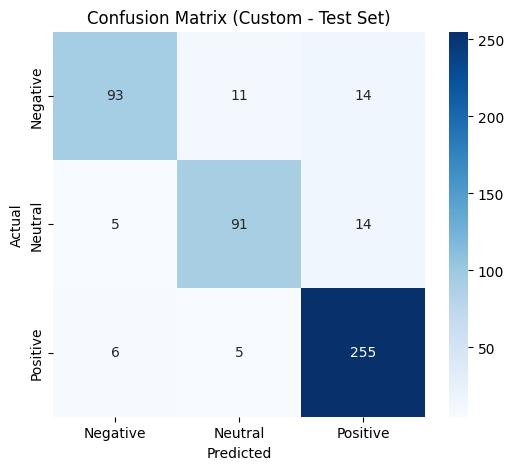

In [19]:
cm = confusion_matrix(y_test, test_results['predictions'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix (Custom - Test Set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
wrong_pred_indices = np.where(y_test != test_results['predictions'])[0]
wrong_predictions_df = pd.DataFrame({
    'Sentence': [X_test[i] for i in wrong_pred_indices],
    'Actual Sentiment': label_encoder.inverse_transform(y_test[wrong_pred_indices]),
    'Predicted Sentiment': label_encoder.inverse_transform(test_results['predictions'][wrong_pred_indices])
})
wrong_predictions_df.to_csv('wrong_predictions_IndoBERT_custom.csv', index=False)

print("\nWrong predictions saved to wrong_predictions_IndoBERT_custom.csv")
display(wrong_predictions_df.head())


Wrong predictions saved to wrong_predictions_IndoBERT_custom.csv


,Sentence,Actual Sentiment,Predicted Sentiment
0,"Hari ini cum dividen ASRM (Rp 65), BIRD (Rp 72...",Neutral,Positive
1,"gatau mas, ta souvenir UNVR yg keren bagiku wk...",Neutral,Positive
2,"cerita dikit pas awal awal kenal investasi,per...",Neutral,Negative
3,TPIA saham aneh ga si? BRPT masih mending lah ...,Negative,Positive
4,inilah update terbaru kapitalisasi market emit...,Negative,Neutral
